<div class="usecase-title">Real-time parking hotspots</div>

<div class="usecase-authors"><b>Authored by: </b> Siju Deng</div>

<div class="usecase-duration"><b>Duration:</b> {90} mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>{Intermediate}</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>{Python, Machine  Learning / Data Wrangling}</div>
</div>

<div class="usecase-section-header">Scenario</div>

As an ordinary living in Melbourne. I want to avoid the difficulty of parking in the city.

* Where is it difficult to park now?
* Is it peak parking time now?

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:

- Get to know the Melbourne city center parking map
- Understand the current parking hotspots in  Melbourne city center
- Learn about multi-file data filtering
- Deepen understanding of snapshot data
- Understand the necessity of data processing

<div class="usecase-section-header">{Purpose and limitations and Run]</div>

# Limitations and Purpose

* This notebook performs exploratory data analysis of Melbourne parking sensor data. Try combining Melbourne parking restriction data with Melbourne parking data. With exploratory analysis, attempts, and assumptions, it's not a rigorous conclusion.

* Due to the snapshot nature of sensor data, the data within the notebook is a historical record of the time the notebook is running. This notebook can only be used as a reference and tutorial and does not have the function of real-time data. Please download and run if necessary. Limited by sensor failures and update issues. Data accuracy is not guaranteed.

# Get and process data

In [1]:
import os
import requests
import pandas as pd

## Input personal api key of City of Melbourne Open Data to get whold data

In [2]:
# Fetch parking data from API
def fetch_parking_data(base_url, dataset, api_key, num_records=99, offset=0):
    all_records = []
    max_offset = 9900  # Set a maximum offset value based on API limitations

    while True:
        if offset > max_offset:
            break

        filters = f'{dataset}/records?limit={num_records}&offset={offset}'
        url = f'{base_url}{filters}&{api_key}'
        try:
            result = requests.get(url, timeout=10)
            result.raise_for_status()
            records = result.json().get('results')
        except requests.exceptions.RequestException as e:
            raise Exception(f"API request failed: {e}")

        if records is None:
            break
        all_records.extend(records)
        if len(records) < num_records:
            break
        offset += num_records

    df = pd.DataFrame(all_records)
    return df

API_KEY = os.environ.get('MELBOURNE_API_KEY', input("Please enter your API key: "))
BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

Please enter your API key: 558000cd83c1d1ba8c4a5e09e0063424750542b70b132293e63b645a


## Data preprocessing

Separate latitude and longitude in data

In [3]:
SENSOR_DATASET = 'on-street-parking-bay-sensors'

df = fetch_parking_data(BASE_URL, SENSOR_DATASET, API_KEY)

# Extract latitude and longitude
df['location_lat'] = df['location'].apply(lambda x: x.get('lat', None))
df['location_lon'] = df['location'].apply(lambda x: x.get('lon', None))

# Drop the original location column
df.drop(columns=['location'], inplace=True)

In [4]:
df

,lastupdated,status_timestamp,zone_number,status_description,parkingbay_id,location_lat,location_lon
0,2023-07-20T05:44:36+00:00,2023-07-19T21:24:38+00:00,7358.0,Unoccupied,7075,-37.814591,144.969350
1,2023-07-20T05:44:36+00:00,2023-07-20T05:23:46+00:00,7358.0,Present,7076,-37.814569,144.969424
2,2023-07-20T05:44:36+00:00,2023-07-20T04:46:01+00:00,7358.0,Unoccupied,7077,-37.814547,144.969500
3,2023-07-24T06:44:36+00:00,2023-07-24T06:16:08+00:00,7638.0,Unoccupied,5852,-37.813205,144.968283
4,2023-07-24T06:44:36+00:00,2023-07-24T05:50:20+00:00,7638.0,Unoccupied,5874,-37.813361,144.968354
...,...,...,...,...,...,...,...
5458,2023-09-22T13:44:36+00:00,2023-09-22T10:57:03+00:00,7273.0,Unoccupied,50657,-37.808140,144.971561
5459,2023-09-22T13:44:36+00:00,2023-09-22T12:55:19+00:00,7541.0,Unoccupied,65868,-37.809068,144.969511
5460,2023-09-22T13:44:36+00:00,2023-09-22T11:46:20+00:00,7672.0,Unoccupied,50672,-37.808635,144.971662
5461,2023-09-22T13:44:36+00:00,2023-09-22T07:24:07+00:00,NaN,Present,7165,-37.817285,144.964270


Check NAN and data type

In [5]:
def validate_data(df):
    print("\nChecking for NaN values:")
    print(df.isna().sum())
    print("\nChecking for Duplicates:")
    print(df.duplicated().sum())
    print("\nChecking data types:")
    print(df.dtypes)

validate_data(df)


Checking for NaN values:
lastupdated             0
status_timestamp        0
zone_number           430
status_description      0
parkingbay_id           0
location_lat            0
location_lon            0
dtype: int64

Checking for Duplicates:
0

Checking data types:
lastupdated            object
status_timestamp       object
zone_number           float64
status_description     object
parkingbay_id           int64
location_lat          float64
location_lon          float64
dtype: object


Since the zone code does not affect the geographical location coordinates and sensor ID, it is not processed. Check and eliminate abnormal time records below. Delete records older than one year.

In [6]:
# Create a new DataFrame for analysis based on the original df
df_analysis = df.copy()

# Convert 'lastupdated' and 'status_timestamp' to datetime objects
df_analysis['lastupdated'] = pd.to_datetime(df_analysis['lastupdated'])
df_analysis['status_timestamp'] = pd.to_datetime(df_analysis['status_timestamp'])

# Identify the most recent timestamp
latest_timestamp = df_analysis['status_timestamp'].max()

# Calculate the date one year ago from the most recent timestamp
one_year_ago = latest_timestamp - pd.DateOffset(years=1)

# Identify rows with 'status_timestamp' older than one year
outdated_rows = df_analysis[df_analysis['status_timestamp'] < one_year_ago].copy()

# Print these outdated rows, sorted by 'status_timestamp'
print("Outdated rows:")
print(outdated_rows.sort_values(by='status_timestamp').head())

# Print the data header sorted by 'status_timestamp'
print("\nData header sorted by time:")
print(df_analysis.sort_values(by='status_timestamp').head())

# Delete outdated rows
df_analysis = df_analysis[df_analysis['status_timestamp'] >= one_year_ago]

Outdated rows:
                   lastupdated          status_timestamp  zone_number  \
4699 2023-09-22 13:44:36+00:00 1970-01-01 00:00:00+00:00       7126.0   
3385 2023-09-22 13:44:36+00:00 2022-07-27 23:03:14+00:00       7062.0   
5258 2023-09-22 13:44:36+00:00 2022-08-02 08:41:19+00:00          NaN   
4981 2023-09-22 13:44:36+00:00 2022-09-13 04:38:23+00:00       7247.0   

     status_description  parkingbay_id  location_lat  location_lon  
4699         Unoccupied           7377    -37.806832    144.965392  
3385         Unoccupied          21358    -37.803218    144.962660  
5258         Unoccupied          24999    -37.809305    144.974109  
4981         Unoccupied          17512    -37.810928    144.976544  

Data header sorted by time:
                   lastupdated          status_timestamp  zone_number  \
4699 2023-09-22 13:44:36+00:00 1970-01-01 00:00:00+00:00       7126.0   
3385 2023-09-22 13:44:36+00:00 2022-07-27 23:03:14+00:00       7062.0   
5258 2023-09-22 13:44:36+0

Based on geographical location coordinates and parking space status and id. Check for duplicate information and eliminate it. Since the retrieval adopts a circular application, duplicate data may be obtained. This step cannot be omitted.

In [7]:
# Detect duplicates based on all columns
duplicates = df_analysis.duplicated(subset=['parkingbay_id','status_description','location_lat','location_lon'], keep=False)

# Display duplicates
print("Duplicate Rows based on all columns are:")
print(df_analysis[duplicates].sort_values('parkingbay_id'))

Duplicate Rows based on all columns are:
Empty DataFrame
Columns: [lastupdated, status_timestamp, zone_number, status_description, parkingbay_id, location_lat, location_lon]
Index: []


In [8]:
# Remove duplicates based on specified columns in df_analysis
df_analysis.drop_duplicates(subset=['parkingbay_id', 'status_description', 'location_lat', 'location_lon', 'lastupdated'], keep='first', inplace=True)

# Data analysis

## Processing

Get the total number of data

In [9]:
# Drop duplicate rows based on 'location_lat' and 'location_lon'
unique_locations = df_analysis.drop_duplicates(subset=['location_lat', 'location_lon'])

# Count the number of unique parking spaces based on location
total_unique_parking_spaces = len(unique_locations)

print(f"The total number of unique parking spaces based on location is {total_unique_parking_spaces}.")

The total number of unique parking spaces based on location is 5255.


Get parking spaces with non-single parking status, based on geographical location.

In [10]:
# Group by latitude and longitude and count occurrences in df_analysis
location_counts = df_analysis.groupby(['location_lat', 'location_lon']).size().reset_index(name='Occurrences')

# Identify locations that appear more than once in df_analysis
duplicate_locations = location_counts[location_counts['Occurrences'] > 1]

# Print out the duplicate locations in df_analysis
if duplicate_locations.empty:
    print("Each geographic location occurs only once.")
else:
    print("Duplicate geographic locations found:")
    print(duplicate_locations)

Duplicate geographic locations found:
      location_lat  location_lon  Occurrences
1385    -37.816188    144.969535            2
1394    -37.816133    144.969509            2
1523    -37.815243    144.969101            2
1532    -37.815196    144.969079            2
1543    -37.815145    144.969056            2
...            ...           ...          ...
3649    -37.808186    144.971581            2
3650    -37.808181    144.971702            2
3651    -37.808162    144.971570            2
3681    -37.807834    144.970084            2
3684    -37.807815    144.970149            2

[203 rows x 3 columns]


Get geolocation with multiple parking space ids

In [11]:
# Filter rows in df_analysis where geographic locations are duplicated
duplicate_locations = df_analysis[df_analysis.duplicated(subset=['location_lat', 'location_lon'], keep=False)]

# Sort these rows in df_analysis by latitude, longitude, and parkingbay_id for easier inspection
sorted_duplicates = duplicate_locations.sort_values(by=['location_lat', 'location_lon', 'parkingbay_id'])

# Print parkingbay_id for duplicate locations in df_analysis
print("parkingbay id for duplicate locations:")
print(sorted_duplicates[['location_lat', 'location_lon', 'parkingbay_id']])

parkingbay id for duplicate locations:
      location_lat  location_lon  parkingbay_id
80      -37.816188    144.969535          17623
4941    -37.816188    144.969535          51636
1896    -37.816133    144.969509          17622
3130    -37.816133    144.969509          51637
3645    -37.815243    144.969101          17619
...            ...           ...            ...
2973    -37.808162    144.971570          50656
56      -37.807834    144.970084           7411
2166    -37.807834    144.970084          66728
1884    -37.807815    144.970149           7410
351     -37.807815    144.970149          66727

[407 rows x 3 columns]


Check if there are duplicate parking space ids

In [12]:
# df_analysis is DataFrame for analysis
duplicate_parking_ids = df_analysis[df_analysis['parkingbay_id'].duplicated(keep=False)]

# Sort the data in df_analysis for easier inspection
duplicate_parking_ids = duplicate_parking_ids.sort_values('parkingbay_id')

if len(duplicate_parking_ids) > 0:
    print("Duplicate parkingbay_id found in df_analysis:")
    print(duplicate_parking_ids[['parkingbay_id', 'location_lat', 'location_lon']])
else:
    print("No duplicate parkingbay_id found in df_analysis.")

No duplicate parkingbay_id found in df_analysis.


Explore the earliest time each parking space is empty

In [13]:
# Filter for 'Unoccupied' status in df_analysis
unoccupied_spaces = df_analysis[df_analysis['status_description'] == 'Unoccupied']

# Sort by 'status_timestamp' in df_analysis
sorted_unoccupied = unoccupied_spaces.sort_values(by='status_timestamp')

# Find the earliest time for each unique parking space based on latitude and longitude in df_analysis
earliest_unoccupied = sorted_unoccupied.drop_duplicates(subset=['location_lat', 'location_lon'], keep='first')

# Display the result
print("The earliest time each parking space was detected as empty in df_analysis:")
print(earliest_unoccupied[['location_lat', 'location_lon', 'status_timestamp']])

The earliest time each parking space was detected as empty in df_analysis:
      location_lat  location_lon          status_timestamp
740     -37.821925    144.954791 2022-10-15 22:53:33+00:00
4377    -37.821944    144.954727 2022-10-16 03:49:10+00:00
413     -37.803458    144.965644 2022-10-24 10:16:58+00:00
4410    -37.802641    144.966506 2022-11-07 21:47:41+00:00
4133    -37.803845    144.949580 2022-11-20 03:44:07+00:00
...            ...           ...                       ...
1038    -37.821092    144.946850 2023-09-22 13:41:47+00:00
3217    -37.812983    144.954284 2023-09-22 13:41:51+00:00
3421    -37.812216    144.969835 2023-09-22 13:41:53+00:00
5050    -37.801891    144.958080 2023-09-22 13:41:55+00:00
1608    -37.809706    144.959077 2023-09-22 13:41:56+00:00

[2549 rows x 3 columns]


Check whether the occupied parking space has previously reported a vacant status.

In [14]:
# Convert to datetime format
df_analysis['lastupdated'] = pd.to_datetime(df_analysis['lastupdated'])
df_analysis['status_timestamp'] = pd.to_datetime(df_analysis['status_timestamp'])

# Sort and filter
sorted_df = df_analysis.sort_values(by=['location_lat', 'location_lon', 'status_timestamp'])
current_vacant = sorted_df[sorted_df['status_description'] == 'Unoccupied'].copy()

# Initialize result DataFrame
result = pd.DataFrame(columns=['location_lat', 'location_lon', 'last_occupied_time'])

# Loop through each vacant space to check its history
for idx, row in current_vacant.iterrows():
    lat, lon, current_time = row['location_lat'], row['location_lon'], row['status_timestamp']
    time_threshold = current_time - pd.Timedelta(hours=3)
    previous_records = sorted_df[(sorted_df['location_lat'] == lat) & (sorted_df['location_lon'] == lon) & (sorted_df['status_timestamp'] >= time_threshold) & (sorted_df['status_description'] == 'Present')]

    if not previous_records.empty:
        last_occupied_time = previous_records['status_timestamp'].max()
        new_row = pd.DataFrame({'location_lat': [lat], 'location_lon': [lon], 'last_occupied_time': [last_occupied_time]})
        result = pd.concat([result, new_row], ignore_index=True)

# Display the result
print("Parking spaces that were occupied a few hours ago and are now vacant:")
print(result)

Parking spaces that were occupied a few hours ago and are now vacant:
    location_lat  location_lon        last_occupied_time
0     -37.816188    144.969535 2023-09-22 13:16:00+00:00
1     -37.816133    144.969509 2023-09-22 13:33:45+00:00
2     -37.814263    144.968769 2023-09-22 13:00:05+00:00
3     -37.814206    144.968619 2023-09-22 11:22:23+00:00
4     -37.814157    144.968596 2023-09-22 13:35:57+00:00
5     -37.813710    144.971402 2023-09-22 12:04:53+00:00
6     -37.813696    144.968940 2023-09-22 08:46:22+00:00
7     -37.813660    144.969065 2023-09-22 10:21:13+00:00
8     -37.813646    144.968484 2023-09-22 13:29:26+00:00
9     -37.813644    144.968946 2023-09-22 10:15:24+00:00
10    -37.813625    144.969010 2023-09-22 13:16:32+00:00
11    -37.813624    144.968474 2023-09-22 12:53:59+00:00
12    -37.813614    144.971358 2023-09-22 13:41:03+00:00
13    -37.813609    144.971187 2023-09-22 11:53:44+00:00
14    -37.813601    144.968464 2023-09-22 13:00:42+00:00
15    -37.813554  

## Analyze results

* It can be found that very few sensors report both statuses. At the same time, some sensors have two parking space ids. Each parking space ID has only one status, and there are no duplicate IDs. It may be due to the nature of the sensor. Because the geographical location is the sensor location, sometimes one sensor can manage two parking spaces.

* It can be determined that this data set is snapshot attribute data. When a sensor reports a state change, the old state is deleted from the data. Also, referring to the official documentation, each sensor will be tested every morning. Today's data is the only reliable data. Other sensors cannot be used due to construction closures and other reasons.

# Data processing

In [15]:
import pytz
from datetime import datetime, timezone

Convert time zone from UTC to Melbourne time

In [16]:
# Create a timezone object for Melbourne
melbourne_tz = pytz.timezone('Australia/Melbourne')

# Get the current time in UTC
current_time_utc = datetime.now(pytz.utc)

# Convert to Melbourne local time
current_time_melbourne = current_time_utc.astimezone(melbourne_tz)

print(f"Current time in UTC: {current_time_utc}")
print(f"Current time in Melbourne: {current_time_melbourne}")

Current time in UTC: 2023-09-22 13:45:14.644975+00:00
Current time in Melbourne: 2023-09-22 23:45:14.644975+10:00


In [17]:
# Convert 'status_timestamp' to Melbourne local time
df_analysis['status_timestamp'] = df_analysis['status_timestamp'].apply(lambda x: x.astimezone(melbourne_tz))

Get today’s data volume

In [18]:
# Get today's date
today_melbourne = current_time_melbourne.date()

# Convert 'status_timestamp' to date only
df_analysis['status_date'] = df_analysis['status_timestamp'].dt.date

# Filter for today's data
todays_data = df_analysis[df_analysis['status_date'] == today_melbourne]

# Count the number of rows
num_rows_today = len(todays_data)

# Display the result
print(f"There are {num_rows_today} rows in today's data.")

There are 4379 rows in today's data.


Get today's data time range

In [19]:
# Find the minimum and maximum timestamps for today's data
min_timestamp_today = todays_data['status_timestamp'].min()
max_timestamp_today = todays_data['status_timestamp'].max()

# Display the result
print(f"The data for today ranges from {min_timestamp_today} to {max_timestamp_today}.")

The data for today ranges from 2023-09-22 00:07:13+10:00 to 2023-09-22 23:41:56+10:00.


Check if there are parking spaces with multiple statuses today

In [20]:
# Group by unique identifier for each parking space and count unique statuses
status_counts = todays_data.groupby(['location_lat', 'location_lon'])['status_description'].nunique().reset_index(name='Unique_Status_Count')

# Filter for parking spaces with more than one unique status
multiple_statuses = status_counts[status_counts['Unique_Status_Count'] > 1]

# Display the result
if multiple_statuses.empty:
    print("No parking spaces with multiple statuses found for today.")
else:
    print("Parking spaces with multiple statuses found for today:")
    print(multiple_statuses)

No parking spaces with multiple statuses found for today.


# Today's data analysis & Visualization

In [21]:
import folium
import matplotlib.pyplot as plt

Sensor visualization of all parking spaces in Melbourne city centre.

In [22]:
# Initialize the map centered around a latitude and longitude
m = folium.Map(location=[-37.814, 144.963], zoom_start=16)  # 16 is the zoom level

# Add points to the map using df_analysis
for idx, row in todays_data.iterrows():
    color = "blue" if row['status_description'] == "Unoccupied" else "red"
    folium.CircleMarker(location=[row['location_lat'], row['location_lon']],
                        radius=1,  # Reduced size
                        color=color,
                        fill=True,
                        fill_color=color).add_to(m)

# Show the map
m

Analyze data time distribution

In [23]:
# Extract the hour from the 'status_timestamp' and create a new column 'update_hour'
todays_data.loc[:,'update_hour'] = todays_data['status_timestamp'].dt.hour
# Create a frequency table for the update times
frequency_table = todays_data['update_hour'].value_counts().sort_index()

# Display the frequency table
print("Frequency table for update times:")
print(frequency_table)

Frequency table for update times:
0        2
3        2
4        1
5        4
6        4
7       10
8       11
9       16
10      18
11      12
12      31
13      41
14      44
15      58
16     147
17     194
18     260
19     230
20     332
21     533
22    1100
23    1329
Name: update_hour, dtype: int64


<ipython-input-23-dbf8c8e813cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  todays_data.loc[:,'update_hour'] = todays_data['status_timestamp'].dt.hour


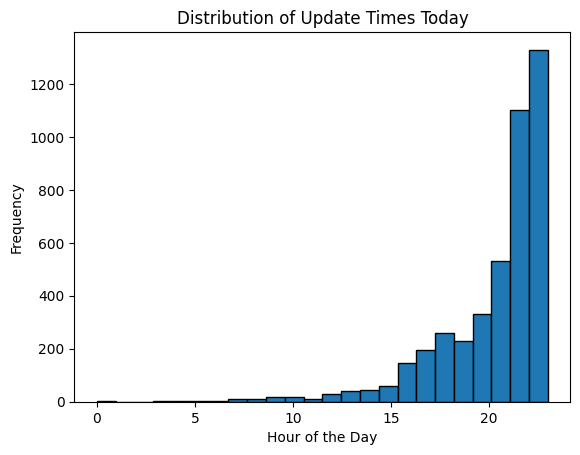

In [24]:
# Plot a histogram for the update times
plt.hist(todays_data['update_hour'], bins=24, edgecolor='black')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Distribution of Update Times Today')
plt.show()

Split into vacant and occupied status to visualize time distribution

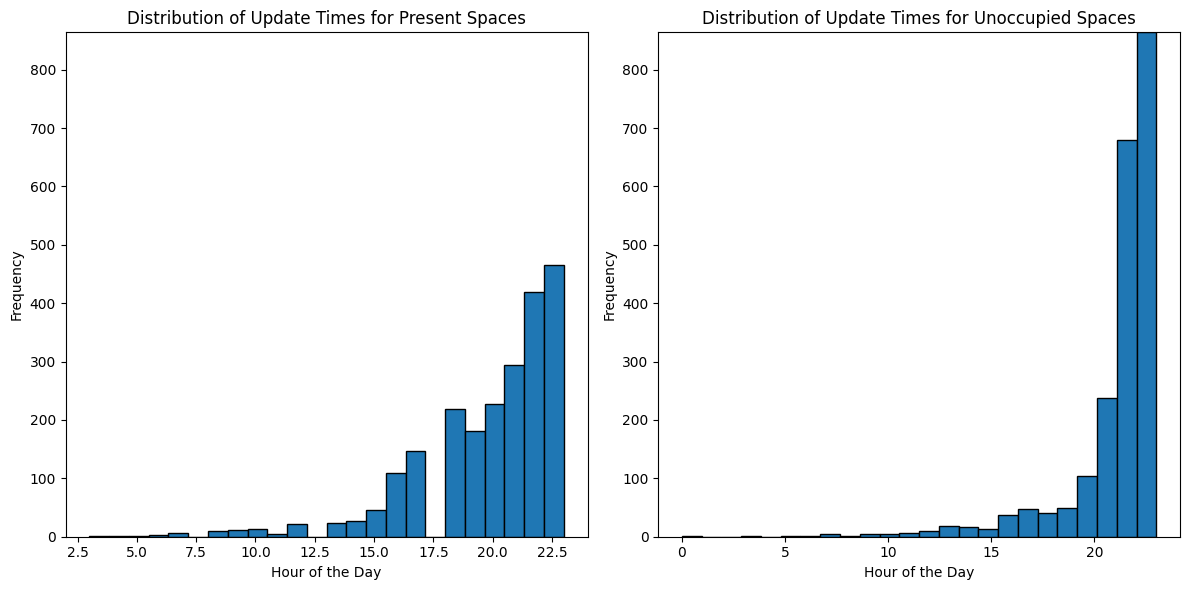

In [25]:
# Filter data for 'Present' and 'Unoccupied' states
present_data = todays_data[todays_data['status_description'] == 'Present']
unoccupied_data = todays_data[todays_data['status_description'] == 'Unoccupied']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Find the maximum frequency to set the same y-axis limit for both subplots
max_frequency = max(
    present_data['update_hour'].value_counts().max(),
    unoccupied_data['update_hour'].value_counts().max()
)

# Plot histogram for 'Present' state
axes[0].hist(present_data['update_hour'], bins=24, edgecolor='black')
axes[0].set_title('Distribution of Update Times for Present Spaces')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Frequency')
axes[0].set_ylim([0, max_frequency])

# Plot histogram for 'Unoccupied' state
axes[1].hist(unoccupied_data['update_hour'], bins=24, edgecolor='black')
axes[1].set_title('Distribution of Update Times for Unoccupied Spaces')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Frequency')
axes[1].set_ylim([0, max_frequency])

# Show the plots
plt.tight_layout()
plt.show()

# Find parking restrictions

A parking space consists of three parts: parking space, parking space description, and sensors. Different departments manage the three and need to call different data sets. By comparing the parking space sensor and the bay's geographical location, the bayid of each geographical location is obtained. Then, get the description of the parking space through bayid.

In [26]:
import pandas as pd

## Get the bayid of the parking space

In [27]:
# On-street Parking Bays
SENSOR_DATASET = 'on-street-parking-bays'
bay_df  = fetch_parking_data(BASE_URL, SENSOR_DATASET, API_KEY)
bay_df

,geo_point_2d,geo_shape,rd_seg_id,marker_id,bay_id,meter_id,rd_seg_dsc,last_edit
0,"{'lon': 144.93563414798302, 'lat': -37.8227455...","{'type': 'Feature', 'geometry': {'coordinates'...",22131,None,7779,None,Lorimer Street between Boundary Street and Ing...,20201223122252
1,"{'lon': 144.98461853185907, 'lat': -37.8299067...","{'type': 'Feature', 'geometry': {'coordinates'...",22716,20086E,3441,None,Anderson Street between Clowes Street and St L...,20201223122245
2,"{'lon': 144.9743972514384, 'lat': -37.81577901...","{'type': 'Feature', 'geometry': {'coordinates'...",22630,None,20418,None,Wellington Parade South between Wellington Cre...,20201208142017
3,"{'lon': 144.96743883205434, 'lat': -37.8110919...","{'type': 'Feature', 'geometry': {'coordinates'...",20151,None,8631,None,Russell Street between Little Bourke Street an...,20201208140729
4,"{'lon': 144.95435921055855, 'lat': -37.7849210...","{'type': 'Feature', 'geometry': {'coordinates'...",None,None,16657,None,None,20201208141616
...,...,...,...,...,...,...,...,...
9994,"{'lon': 144.981172907813, 'lat': -37.809266435...","{'type': 'Feature', 'geometry': {'coordinates'...",20897,None,23579,None,Eades Street between Victoria Parade and Alber...,20210426122440
9995,"{'lon': 144.9697047894569, 'lat': -37.79748816...","{'type': 'Feature', 'geometry': {'coordinates'...",20817,None,1932,None,Elgin Street between Rathdowne Street and Drum...,20201223122240
9996,"{'lon': 144.96953780147317, 'lat': -37.7990112...","{'type': 'Feature', 'geometry': {'coordinates'...",20710,None,1052,None,Faraday Street between Rathdowne Street and Dr...,20201223122240
9997,"{'lon': 144.9568773900466, 'lat': -37.80935750...","{'type': 'Feature', 'geometry': {'coordinates'...",None,C6776,18947,None,None,20201208141838


There is a limit on the amount of data when using the API. Use a download connection to access data to bypass the API limit.

In [28]:
# Replace 'your_download_link_here' with the actual download link
download_link = 'https://melbournetestbed.opendatasoft.com/api/explore/v2.1/catalog/datasets/on-street-parking-bays/exports/csv?lang=en&timezone=Australia%2FSydney&use_labels=true&delimiter=%2C'

# Read the CSV into a DataFrame
bay_df = pd.read_csv(download_link)

bay_df

,Geo Point,Geo Shape,rd_seg_id,marker_id,bay_id,meter_id,rd_seg_dsc,last_edit
0,"-37.822745543141885, 144.93563414798302","{""coordinates"": [[[[144.935660692658, -37.8227...",22131.0,NaN,7779,NaN,Lorimer Street between Boundary Street and Ing...,2.020122e+13
1,"-37.829906719140936, 144.98461853185907","{""coordinates"": [[[[144.984609469935, -37.8298...",22716.0,20086E,3441,NaN,Anderson Street between Clowes Street and St L...,2.020122e+13
2,"-37.81577901759838, 144.9743972514384","{""coordinates"": [[[[144.974436061605, -37.8157...",22630.0,NaN,20418,NaN,Wellington Parade South between Wellington Cre...,2.020121e+13
3,"-37.81109191560869, 144.96743883205434","{""coordinates"": [[[[144.967478832912, -37.8111...",20151.0,NaN,8631,NaN,Russell Street between Little Bourke Street an...,2.020121e+13
4,"-37.78492101931813, 144.95435921055855","{""coordinates"": [[[[144.95435109635, -37.78489...",NaN,NaN,16657,NaN,NaN,2.020121e+13
...,...,...,...,...,...,...,...,...
24710,"-37.80354278805992, 144.90939323833106","{""coordinates"": [[[[144.909367127839, -37.8035...",21685.0,NaN,8176,NaN,Sims Street between Dynon Road and Footscray Road,2.020122e+13
24711,"-37.833092152695706, 144.97911760560535","{""coordinates"": [[[[144.979154326666, -37.8330...",22706.0,NaN,4809,NaN,Birdwood Avenue between Dallas Brooks Drive an...,2.020122e+13
24712,"-37.816704151071775, 144.96209122121158","{""coordinates"": [[[[144.96212717236, -37.81670...",20114.0,2002N,9140,NaN,Collins Street between Elizabeth Street and Qu...,2.020121e+13
24713,"-37.804767107741924, 144.94676736431666","{""coordinates"": [[[[144.946734125446, -37.8047...",21007.0,NaN,4684,NaN,Victoria Street between Curzon Street and Abbo...,2.020122e+13


Split latitude and longitude

In [29]:
bay_df['location_lat'], bay_df['location_lon'] = bay_df['Geo Point'].str.split(',', n=1).str

# Convert them to float for numerical operations
bay_df['location_lat'] = bay_df['location_lat'].astype(float)
bay_df['location_lon'] = bay_df['location_lon'].astype(float)

# Display the DataFrame
bay_df.head()

<ipython-input-29-6be6781613a6>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  bay_df['location_lat'], bay_df['location_lon'] = bay_df['Geo Point'].str.split(',', n=1).str


,Geo Point,Geo Shape,rd_seg_id,marker_id,bay_id,meter_id,rd_seg_dsc,last_edit,location_lat,location_lon
0,"-37.822745543141885, 144.93563414798302","{""coordinates"": [[[[144.935660692658, -37.8227...",22131.0,NaN,7779,NaN,Lorimer Street between Boundary Street and Ing...,2.020122e+13,-37.822746,144.935634
1,"-37.829906719140936, 144.98461853185907","{""coordinates"": [[[[144.984609469935, -37.8298...",22716.0,20086E,3441,NaN,Anderson Street between Clowes Street and St L...,2.020122e+13,-37.829907,144.984619
2,"-37.81577901759838, 144.9743972514384","{""coordinates"": [[[[144.974436061605, -37.8157...",22630.0,NaN,20418,NaN,Wellington Parade South between Wellington Cre...,2.020121e+13,-37.815779,144.974397
3,"-37.81109191560869, 144.96743883205434","{""coordinates"": [[[[144.967478832912, -37.8111...",20151.0,NaN,8631,NaN,Russell Street between Little Bourke Street an...,2.020121e+13,-37.811092,144.967439
4,"-37.78492101931813, 144.95435921055855","{""coordinates"": [[[[144.95435109635, -37.78489...",NaN,NaN,16657,NaN,NaN,2.020121e+13,-37.784921,144.954359


The longitude and latitude blur processing, bay, and sensor are not completely overlapping. They are two different devices. Therefore, some latitude and longitude blurring is required.

In [30]:
# Round latitude and longitude to 6 decimal places
df_analysis['location_lat'] = df_analysis['location_lat'].round(8)
df_analysis['location_lon'] = df_analysis['location_lon'].round(8)
bay_df['location_lat'] = bay_df['location_lat'].round(8)
bay_df['location_lon'] = bay_df['location_lon'].round(8)


Integrate and add bayid to parking sensor

In [31]:
# Perform a left merge to add bay_id to df_analysis
df_analysis = pd.merge(df_analysis, bay_df[['location_lat', 'location_lon', 'bay_id']],
                       how='left',
                       left_on=['location_lat', 'location_lon'],
                       right_on=['location_lat', 'location_lon'])

In [32]:
df_analysis

,lastupdated,status_timestamp,zone_number,status_description,parkingbay_id,location_lat,location_lon,status_date,bay_id
0,2023-07-20 05:44:36+00:00,2023-07-20 07:24:38+10:00,7358.0,Unoccupied,7075,-37.814591,144.969350,2023-07-20,NaN
1,2023-07-20 05:44:36+00:00,2023-07-20 15:23:46+10:00,7358.0,Present,7076,-37.814569,144.969424,2023-07-20,NaN
2,2023-07-20 05:44:36+00:00,2023-07-20 14:46:01+10:00,7358.0,Unoccupied,7077,-37.814547,144.969500,2023-07-20,NaN
3,2023-07-24 06:44:36+00:00,2023-07-24 16:16:08+10:00,7638.0,Unoccupied,5852,-37.813205,144.968283,2023-07-24,NaN
4,2023-07-24 06:44:36+00:00,2023-07-24 15:50:20+10:00,7638.0,Unoccupied,5874,-37.813361,144.968354,2023-07-24,NaN
...,...,...,...,...,...,...,...,...,...
5455,2023-09-22 13:44:36+00:00,2023-09-22 20:57:03+10:00,7273.0,Unoccupied,50657,-37.808140,144.971561,2023-09-22,NaN
5456,2023-09-22 13:44:36+00:00,2023-09-22 22:55:19+10:00,7541.0,Unoccupied,65868,-37.809068,144.969511,2023-09-22,NaN
5457,2023-09-22 13:44:36+00:00,2023-09-22 21:46:20+10:00,7672.0,Unoccupied,50672,-37.808635,144.971662,2023-09-22,NaN
5458,2023-09-22 13:44:36+00:00,2023-09-22 17:24:07+10:00,NaN,Present,7165,-37.817285,144.964270,2023-09-22,NaN


Find out how many empty bayids there are in total.

In [33]:
# Count the number of NaN values in the 'bay_id' column
num_nan = df_analysis['bay_id'].isna().sum()

print(f"There are {num_nan} NaN values in the 'bay_id' column.")

There are 3867 NaN values in the 'bay_id' column.


Find out how many empty bayids there are in today’s data

In [34]:
# Filter to only include today's data
todays_data = df_analysis[df_analysis['status_date'] == today_melbourne]

# Count the number of NaN values in the 'bay_id' column for today's data
num_nan_today = todays_data['bay_id'].isna().sum()

print(f"There are {num_nan_today} NaN values in the 'bay_id' column for today's data.")

There are 3147 NaN values in the 'bay_id' column for today's data.


## Get parking space description

In [35]:
# Define the new dataset name for On-street Parking Bay Sensors
NEW_SENSOR_DATASET = 'on-street-car-park-bay-restrictions'
limit_df = fetch_parking_data(BASE_URL, NEW_SENSOR_DATASET, API_KEY)
print(limit_df.head())

   bayid  deviceid                    description1            description2  \
0   1500     30574  LZ 30MINS 722 M-F 7.30 to 6.30  2P MTR M-F 18:30-20:30   
1   8167     25546             1P M-SUN 7:30-23:00                    None   
2   8575     27944      2P RPA 1B 7:30-23:00 M-SUN                    None   
3   7981     25360         2P TKT M-SUN7:30AM-11PM                    None   
4   8152     25531             1P M-SUN 7:30-23:00                    None   

            description3 description4 description5 description6  \
0  2P MTR SAT 7:30-20:30         None         None         None   
1                   None         None         None         None   
2                   None         None         None         None   
3                   None         None         None         None   
4                   None         None         None         None   

   disabilityext1  disabilityext2  ...  today3  today4  today5  today6  \
0               0           240.0  ...     6.0     NaN

In [36]:
limit_df

,bayid,deviceid,description1,description2,description3,description4,description5,description6,disabilityext1,disabilityext2,...,today3,today4,today5,today6,typedesc1,typedesc2,typedesc3,typedesc4,typedesc5,typedesc6
0,1500,30574,LZ 30MINS 722 M-F 7.30 to 6.30,2P MTR M-F 18:30-20:30,2P MTR SAT 7:30-20:30,None,None,None,0,240.0,...,6.0,NaN,NaN,NaN,Loading Zone 30M 722,2P Meter,2P Meter,None,None,None
1,8167,25546,1P M-SUN 7:30-23:00,None,None,None,None,None,120,NaN,...,NaN,NaN,NaN,NaN,1P,None,None,None,None,None
2,8575,27944,2P RPA 1B 7:30-23:00 M-SUN,None,None,None,None,None,240,NaN,...,NaN,NaN,NaN,NaN,2P,None,None,None,None,None
3,7981,25360,2P TKT M-SUN7:30AM-11PM,None,None,None,None,None,240,NaN,...,NaN,NaN,NaN,NaN,2P Ticket A,None,None,None,None,None
4,8152,25531,1P M-SUN 7:30-23:00,None,None,None,None,None,120,NaN,...,NaN,NaN,NaN,NaN,1P,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,8247,25626,P5 M-SUN 7:30-18:30,1P M-SUN 6:30PM-11PM,None,None,None,None,10,120.0,...,NaN,NaN,NaN,NaN,P 05 Min,1P,None,None,None,None
4259,3541,30469,3P MTR M-SAT 7:30-20:30,None,None,None,None,None,360,NaN,...,NaN,NaN,NaN,NaN,3P Meter,None,None,None,None,None
4260,8226,25614,1P M-SUN 7:30-23:00,None,None,None,None,None,120,NaN,...,NaN,NaN,NaN,NaN,1P,None,None,None,None,None
4261,6281,26325,2P MTR M-SAT 7:30-18:30,2P SUN 7:30-18:30,None,None,None,None,240,240.0,...,NaN,NaN,NaN,NaN,2P Meter,2P,None,None,None,None


Get the columns description1-5 about the parking space restriction description. After online inspection on On-street Car Park Bay Restrictions, although description6 is marked as a time limit description, it is actually marked as January 1, AD1. There is no data description at the same time, so it is excluded manually.

In [37]:
# Merge df_analysis with only the relevant columns from limit_df
columns_to_merge = ['bayid', 'description1', 'description2', 'description3', 'description4', 'description5']
merged_df = pd.merge(df_analysis, limit_df[columns_to_merge], left_on='bay_id', right_on='bayid', how='left')

# Drop the 'bayid' column from the right DataFrame to avoid duplicate columns
merged_df.drop(columns=['bayid'], inplace=True)

# Display the DataFrame
print(merged_df.head())

                lastupdated          status_timestamp  zone_number  \
0 2023-07-20 05:44:36+00:00 2023-07-20 07:24:38+10:00       7358.0   
1 2023-07-20 05:44:36+00:00 2023-07-20 15:23:46+10:00       7358.0   
2 2023-07-20 05:44:36+00:00 2023-07-20 14:46:01+10:00       7358.0   
3 2023-07-24 06:44:36+00:00 2023-07-24 16:16:08+10:00       7638.0   
4 2023-07-24 06:44:36+00:00 2023-07-24 15:50:20+10:00       7638.0   

  status_description  parkingbay_id  location_lat  location_lon status_date  \
0         Unoccupied           7075    -37.814591    144.969350  2023-07-20   
1            Present           7076    -37.814569    144.969424  2023-07-20   
2         Unoccupied           7077    -37.814547    144.969500  2023-07-20   
3         Unoccupied           5852    -37.813205    144.968283  2023-07-24   
4         Unoccupied           5874    -37.813361    144.968354  2023-07-24   

   bay_id description1 description2 description3 description4 description5  
0     NaN          NaN     

Add time limits to each parking space

In [38]:
# Columns to check for "DIS"
columns_to_check = ['description1', 'description2', 'description3', 'description4', 'description5']

# Find rows where any of the specified columns contain "DIS"
contains_dis = merged_df[columns_to_check].apply(lambda x: x.str.contains('DIS')).any(axis=1)

# Extract rows with "DIS" into a separate DataFrame
disabled_parking_df = merged_df[contains_dis]

# Delete rows with "DIS" from the original DataFrame
merged_df = merged_df[~contains_dis]

# Display the new DataFrames
print("Disabled Parking Data:")
print(disabled_parking_df.head())

print("Remaining Data:")
print(merged_df.head())

Disabled Parking Data:
Empty DataFrame
Columns: [lastupdated, status_timestamp, zone_number, status_description, parkingbay_id, location_lat, location_lon, status_date, bay_id, description1, description2, description3, description4, description5]
Index: []
Remaining Data:
                lastupdated          status_timestamp  zone_number  \
0 2023-07-20 05:44:36+00:00 2023-07-20 07:24:38+10:00       7358.0   
1 2023-07-20 05:44:36+00:00 2023-07-20 15:23:46+10:00       7358.0   
2 2023-07-20 05:44:36+00:00 2023-07-20 14:46:01+10:00       7358.0   
3 2023-07-24 06:44:36+00:00 2023-07-24 16:16:08+10:00       7638.0   
4 2023-07-24 06:44:36+00:00 2023-07-24 15:50:20+10:00       7638.0   

  status_description  parkingbay_id  location_lat  location_lon status_date  \
0         Unoccupied           7075    -37.814591    144.969350  2023-07-20   
1            Present           7076    -37.814569    144.969424  2023-07-20   
2         Unoccupied           7077    -37.814547    144.969500  2023

Time limit to check how many parking spaces are empty.

In [39]:
# Columns to check for NaN values
columns_to_check = ['description1', 'description2', 'description3', 'description4', 'description5']

# Find rows where all specified columns are NaN
all_nan_rows = merged_df[columns_to_check].isna().all(axis=1)

# Count the number of such rows
num_all_nan_rows = all_nan_rows.sum()

# Display the count
print(f"Number of rows where all of the specified columns are NaN: {num_all_nan_rows}")

Number of rows where all of the specified columns are NaN: 5280


## Conclusion

* We have integrated bay_id and parking space restrictions for each parking space. The existence number is unchanged.

* Through inspection, it can be found that the time limits of the parking spaces where most parking space sensors are located have not been integrated into the database. The lack of parking spaces is inconsistent with the reality.

* Three different systems or departments provide the three databases of parking space sensors, parking spaces, and parking restrictions. Missing data can be encountered. We will assume parking time restrictions.

# Today's parking space analysis

Due to the no parking space time limit, we will assume that the parking space time limit is 2 hours. The average parking time is 1 hour. Because the parking space sensor provides a snapshot, the sensor only records the most recent state. Pushing the collected empty parking spaces forward one hour is the assumed parking start time. Can analyze the theoretical last parking peak period.

## Time processing

In [40]:
from pandas.tseries.offsets import Minute
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import folium

In [41]:
# Step 1: Create a copy of today's data
todays_data_copy = todays_data.copy()

# Step 2: Filter to only include rows where the parking space is vacant
vacant_indices = todays_data_copy[todays_data_copy['status_description'] == 'Unoccupied'].index

# Step 3: Subtract 60 minutes from the timestamp of these vacant spaces
todays_data_copy.loc[vacant_indices, 'status_timestamp'] = todays_data_copy.loc[vacant_indices, 'status_timestamp'] - Minute(60)

# Step 4: Update the 'status_date' column based on the new 'status_timestamp'
todays_data_copy['status_date'] = todays_data_copy['status_timestamp'].dt.date

# Step 4: Change the status of these advanced-time vacant spaces to 'Occupied'
todays_data_copy.loc[vacant_indices, 'status_description'] = 'Occupied'

# Step 5: Remove rows where the 'status_date' is not today
todays_data_copy = todays_data_copy[todays_data_copy['status_date'] == today_melbourne]

## Popular parking hours

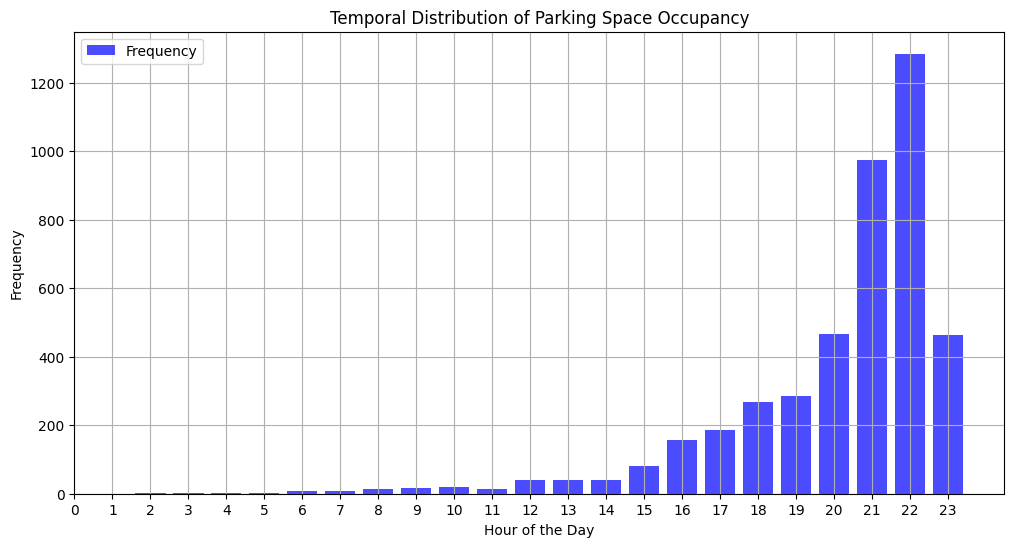

In [42]:
# Convert 'status_timestamp' to just the hour of the day
todays_data_copy['status_hour'] = todays_data_copy['status_timestamp'].dt.hour

# Create a frequency table for the update times
frequency_table = todays_data_copy['status_hour'].value_counts().sort_index()

# Plot a histogram for the update times
plt.figure(figsize=(12, 6))
plt.bar(frequency_table.index, frequency_table.values, color='blue', alpha=0.7, label='Frequency')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Temporal Distribution of Parking Space Occupancy')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.show()

If time is even, it can be considered that the parking peak is still in progress. If it has started to decline, it can be considered that the previous peak has passed.

## Parking hotspot visualization

Today's parking spaces are clustered and marked on the map.

In [43]:
# Create a new DataFrame with only the latitude and longitude columns
X = todays_data_copy[['location_lat', 'location_lon']].values

# Run DBSCAN clustering
dbscan = DBSCAN(eps=0.0005, min_samples=20)
labels = dbscan.fit_predict(X)

# Add cluster labels back to DataFrame
todays_data_copy['cluster_label'] = labels

# Calculate the centroid of each cluster
cluster_centroids = todays_data_copy.groupby('cluster_label').agg({'location_lat': 'mean', 'location_lon': 'mean'}).reset_index()

# Initialize the map
m = folium.Map(location=[-37.814, 144.963], zoom_start=16)

# Add circles for each cluster
for idx, row in cluster_centroids.iterrows():
    if row['cluster_label'] != -1:  # -1 is the label for noise points in DBSCAN
        folium.Circle(
            location=[row['location_lat'], row['location_lon']],
            radius=50,  # Radius
            color='blue',
            fill=True,
            fill_color='blue'
        ).add_to(m)

# Show the map
m

# Conclusion

> Multiple analysis methods have been tried so far. Try combining multiple APIs. But, due to the lack of parking space time limits and the snapshot nature of the sensors. We can only analyze theoretical parking hotspots. There is a deviation from the actual situation. <br/>

> If we need to analyze the possibility of a long time, we need to deploy the server in real time for a long time. It is difficult for ordinary readers to reproduce and operate. <br/>

> This analysis is intended for data exploration. At the same time, it provides analysis reference for data that cannot be updated and integrated. Guide readers to realize the importance of data screening and processing. Presenting unprocessed data requires repeated analysis and screening. Provide a reference for data processing ideas.